In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tkinter as tk
from tkinter import ttk
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report,r2_score
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from tkinter import messagebox

- This is the block for importing all of the necessary libraries for the project.

# Data Validation,Cleaning and optmization

- This block is for reading the dataset and displaying the first few rows in order to gather vital information

In [23]:
df = pd.read_csv('Dataset/heart_disease_uci.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


- Checking the Values of (Y)

In [24]:
df['num'].value_counts()
# Numbers here show the severity of heart disease
#from 0 to 2 the severity is low
# from 3 to 4 the severity is high

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

In [25]:
df['num'] = df['num'].replace({0: 'No Heart Disease',
                            1: 'No Heart Disease',
                            2: 'No Heart Disease',
                            3: 'Heart Disease',
                            4: 'Heart Disease'})

- This block is for dropping the irrelevant columns and checking for null values and gathering information in order to fill them in the next block.

In [26]:

#id and dataset are irrelevant/unused columns
df = df.drop(columns=['id', 'dataset'])
#check for null values
print(df.isnull().sum())

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


- This block is for filling the missing values in the dataset.

In [27]:
#For numerical columns (trestbps, chol, thalch, oldpeak) we fill them with the median of the column

median_columns = ['trestbps', 'chol', 'thalch', 'oldpeak']
for col in median_columns:
    df[col] = df[col].fillna(df[col].median())
#but for the categorical columns (cp,restecg,slope, ca, thal) >Contains strings<
#we fill them with the mode of the column
mode_columns = ['cp', 'restecg', 'slope', 'ca', 'thal']
for col in mode_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

#check for null values again
print(df.isnull().sum())


age          0
sex          0
cp           0
trestbps     0
chol         0
fbs         90
restecg      0
thalch       0
exang       55
oldpeak      0
slope        0
ca           0
thal         0
num          0
dtype: int64


In [28]:
# Label encode binary columns (e.g., 'sex', 'fbs', 'exang') >changing text into numbers:
    # sex: Binary (Male/Female → 1/0).
    # fbs: Binary (fasting blood sugar > 120 mg/dL: True/False → 1/0).
    # exang: Binary (exercise-induced angina: Yes/No → 1/0).

le = LabelEncoder() 
df['sex'] = le.fit_transform(df['sex'])  # Male=1, Female=0
df['fbs'] = le.fit_transform(df['fbs'])
df['exang'] = le.fit_transform(df['exang'])


#One-hot encoding creates binary columns for each category in a multi-class feature
df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope', 'thal'])

# Data Visualization

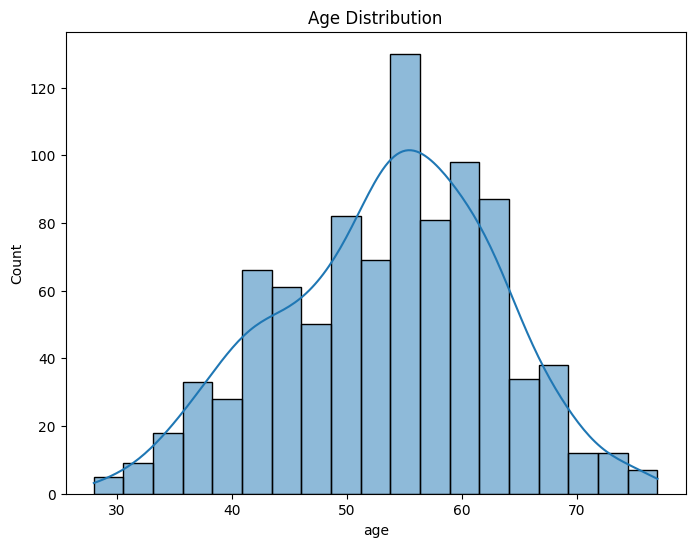

In [29]:
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

- Bivariate Exploration

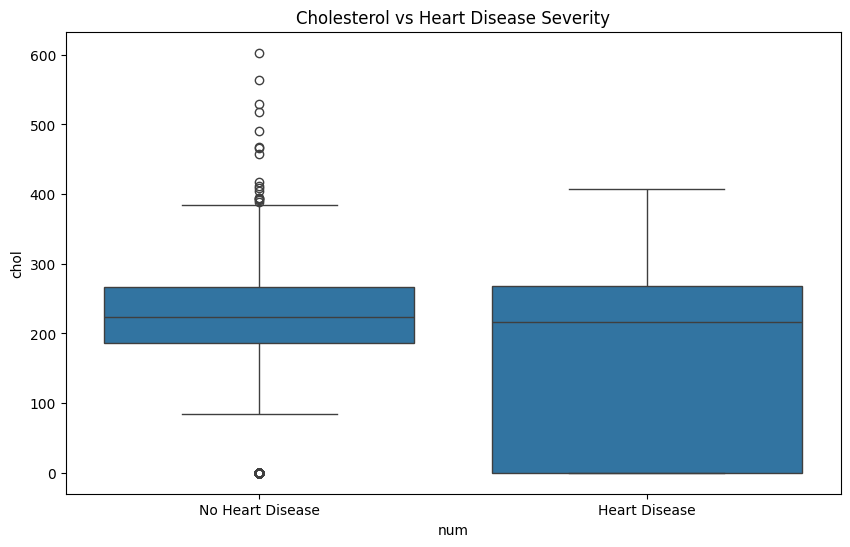

In [30]:
# Compare cholesterol levels by target class
plt.figure(figsize=(10, 6))
sns.boxplot(x='num', y='chol', data=df)
plt.title('Cholesterol vs Heart Disease Severity')
plt.show()

- Multivariate Exploration

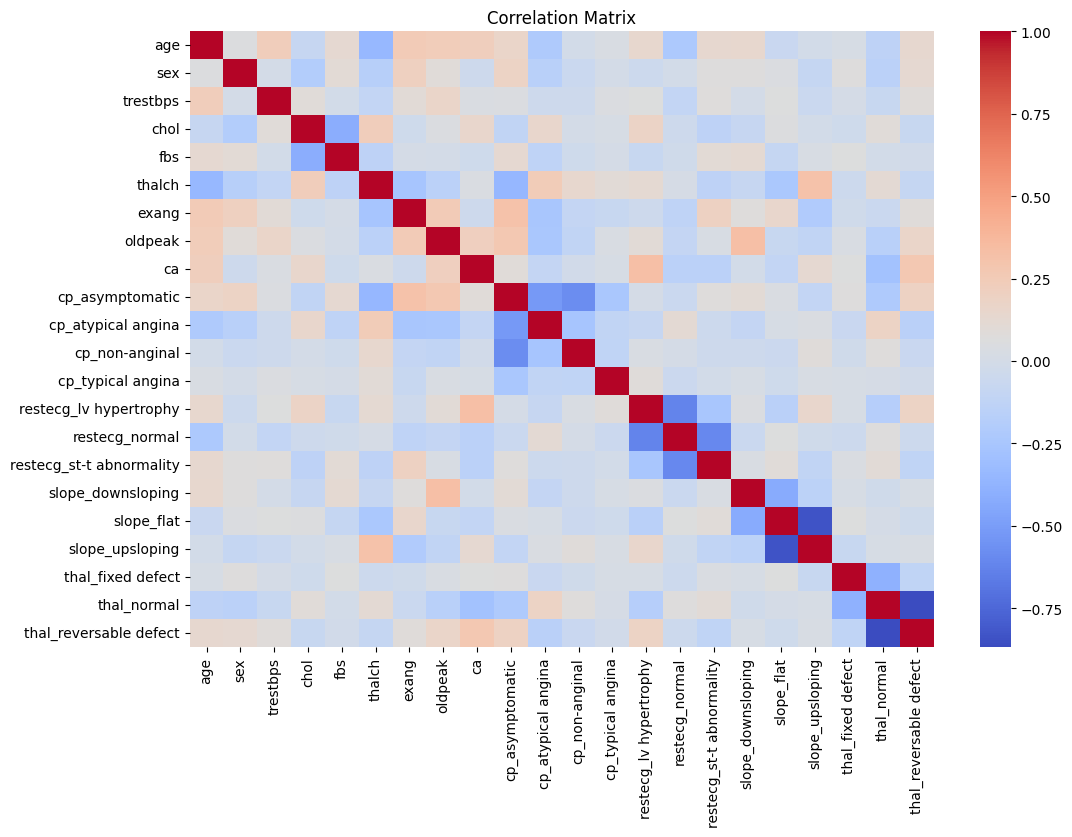

In [31]:
# Correlation matrix (exclude non-numeric 'num' column)
plt.figure(figsize=(12, 8))
corr = df.drop(columns=['num']).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- discovery between data and each other without the output

### From data visualization it's clear that most of the data affects the output and important such as sex,RBP,Age,cholesterol and so on
- This information is important for usage of the Tkinter Application

# Preprocessing (Prepare data for modeling)

In [32]:
# Separate features and target
X = df.drop(columns=['num'])
y = df['num']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
y = y.map({'No Heart Disease': 0, 'Heart Disease': 1})
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

### Changed the outputs into binary 0,1 for easy coding

# Principal Component Analysis (PCA)

## Reducing the dimensionality of large datasets while preserving the most significant information

In [34]:
PCA = PCA(n_components=2)
PCA_X = PCA.fit_transform(X_scaled)
new_data = pd.DataFrame(data=PCA_X, columns=['PCA1', 'PCA2'])

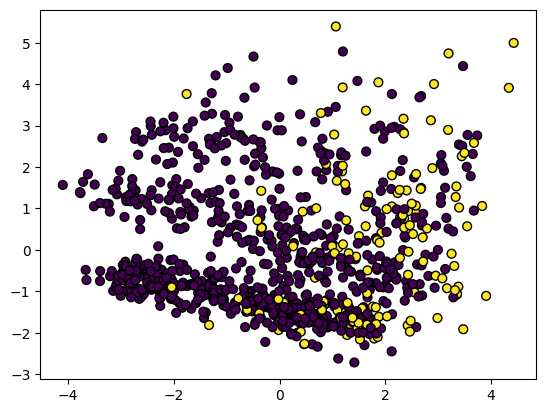

In [35]:
plt.scatter(new_data['PCA1'], new_data['PCA2'], c=y, cmap='viridis', edgecolor='k', s=40)

# Model Evaluation (Compare models and select the best performer)

## And choosing the best Model

In [36]:
# Initialize models
models = {
    'XGBoost Classifier': XGBClassifier(),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100),
}

# Evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Testing the models
    accuracy = accuracy_score(y_test, y_pred)
    print(f'\n{name} Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, y_pred))
    
cross_val_score(model, X, y, cv=5, scoring='r2')


XGBoost Classifier Results:
Accuracy: 0.8587
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       154
           1       0.64      0.30      0.41        30

    accuracy                           0.86       184
   macro avg       0.76      0.63      0.66       184
weighted avg       0.84      0.86      0.84       184


Random Forest Classifier Results:
Accuracy: 0.8261
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       154
           1       0.33      0.07      0.11        30

    accuracy                           0.83       184
   macro avg       0.59      0.52      0.51       184
weighted avg       0.76      0.83      0.77       184



array([-0.30219391, -0.21538099, -0.12856806, -1.12691673, -1.995046  ])

- Best choice for the application and modeling is XGBoost since it got a higher accuracy (f1) than random forest

# GridSearch Cross-Validation

## using xgboost

In [37]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
grid = GridSearchCV(XGBClassifier(), param_grid, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.7}
Best cross-validation accuracy: 0.8627964699393271


In [38]:
X = df.drop(columns=['num'])  # Features
y = df['num']                 # Target Variable 0 or 1
y = y.map({'No Heart Disease': 0, 'Heart Disease': 1})
# Normalize numerical features

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the model
xg_model = XGBClassifier(n_estimators=100)
xg_model.fit(X_train, y_train)
preds = model.predict(X_test)

# Predict on test data
y_pred = xg_model.predict(X_test)

# Evaluate performance
#mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

#print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (accuracy²): {acc:.2f}")

R-squared (accuracy²): 0.86


- Training the model and achieved accracy 0.86

In [39]:
# Save model
joblib.dump(xg_model, "Model/heart_disease_model.pkl")

# Save scaler if used
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "Model/scaler.pkl")

# Also save the column order
joblib.dump(X.columns.tolist(), "Model/feature_columns.pkl")

['Model/feature_columns.pkl']

In [41]:
# Load the trained model, scaler, and feature columns
model = joblib.load("Model/heart_disease_model.pkl")
scaler = joblib.load("Model/scaler.pkl")
feature_columns = joblib.load("Model/feature_columns.pkl")

# Create the main application window
root = tk.Tk()
root.title("Heart Disease Prediction")
root.iconphoto(False, tk.PhotoImage(file="icon.png"))
root.geometry("400x600")

# Define input fields
input_fields = {
    "age": {"label": "Age", "type": "spinbox", "hint": "Select your age (18+)", "min": 18, "max": 120},
    "sex": {"label": "Sex", "type": "radio", "options": {"Male": 1, "Female": 0}},
    "fbs": {"label": "Fasting Blood Sugar > 120 mg/dL", "type": "radio", "options": {"Yes": 1, "No": 0}},
    "trestbps": {"label": "Resting Blood Pressure", "type": "entry", "hint": "e.g., 120 mmHg"},
    "chol": {"label": "Cholesterol Level", "type": "entry", "hint": "e.g., 200 mg/dL"},
    "thalch": {"label": "Maximum Heart Rate Achieved", "type": "entry", "hint": "average bpm = 70"},
    "exang": {"label": "Exercise-Induced Angina", "type": "radio", "options": {"Yes": 1, "No": 0}},
    "oldpeak": {"label": "ST Depression Induced by Exercise", "type": "entry", "hint": "e.g., 1.5"},
    "ca": {"label": "Number of Major Vessels (0-3)", "type": "entry", "hint": "e.g., 2"},
    "slope": {"label": "Slope of the Peak Exercise ST Segment", "type": "combobox", "options": {"Up": 1, "Flat": 0, "Down": -1}},
    "restecg": {"label": "Resting Electrocardiographic Results", "type": "combobox", "options": {"Normal": 0, "ST-T Wave Abnormality": 1, "Left Ventricular Hypertrophy": 2}},
    "cp": {"label": "Chest Pain Type", "type": "combobox", "options": {"Typical Angina": 1, "Atypical Angina": 0, "Non-Anginal Pain": -1, "Asymptomatic": -2}},
    "thal": {"label": "Thalassemia", "type": "combobox", "options": {"Normal": 1, "Fixed Defect": 0, "Reversible Defect": -1}},
}

entries = {}

# Create input fields dynamically

for idx, (key, field) in enumerate(input_fields.items()):
    label = tk.Label(root, text=field["label"])
    label.grid(row=idx, column=0, padx=10, pady=5, sticky="w")
    
    if field["type"] == "entry":
        entry = tk.Entry(root, fg="gray")  # Default color is gray for placeholder
        entry.insert(0, field.get("hint", ""))  # Insert the hint text

        # Define focus-in behavior
        def on_focus_in(event, entry=entry, hint=field.get("hint", "")):
            if entry.get() == hint:
                entry.delete(0)  # Remove placeholder text
                entry.config(fg="black")  # Change text color to black

        # Define focus-out behavior
        def on_focus_out(event, entry=entry, hint=field.get("hint", "")):
            if entry.get() == "":  # If the field is empty
                entry.insert(0, hint)  # Restore placeholder text
                entry.config(fg="gray")  # Change text color back to gray

        # Bind focus-in and focus-out events
        entry.bind("<FocusIn>", on_focus_in)
        entry.bind("<FocusOut>", on_focus_out)

        entry.grid(row=idx, column=1, padx=10, pady=5)
        entries[key] = entry
    elif field["type"] == "radio":
        var = tk.IntVar(value=list(field["options"].values())[0])  # Default to the first option
        radio_frame = tk.Frame(root)  # Group radio buttons together
        radio_frame.grid(row=idx, column=1, padx=10, pady=5, sticky="w")
        for opt_label, opt_value in field["options"].items():
            radio = tk.Radiobutton(radio_frame, text=opt_label, variable=var, value=opt_value)
            radio.pack(side="left", padx=5)  # Align radio buttons horizontally
        entries[key] = var
    elif field["type"] == "combobox":
        cb = ttk.Combobox(root, values=list(field["options"].keys()), state="readonly", width=20)
        cb.set(list(field["options"].keys())[0])
        cb.grid(row=idx, column=1, padx=10, pady=5)
        entries[key] = cb
        entries[key] = var
    elif field["type"] == "spinbox":
        spinbox = tk.Spinbox(root, from_=field["min"], to=field["max"], width=5)
        spinbox.grid(row=idx, column=1, padx=10, pady=5)
        spinbox.bind("<MouseWheel>", lambda e, sb=spinbox: sb.invoke("buttonup" if e.delta > 0 else "buttondown"))  # Enable mouse scroll
        entries[key] = spinbox

# Prediction function
def predict():
    try:
        # Collect user input
        user_input = []
        for key, field in input_fields.items():
            if field["type"] == "radio":
                value = entries[key].get()
            elif field["type"] == "spinbox":
                value = int(entries[key].get())
            else:
                value = float(entries[key].get())
            user_input.append(value)
        
        # Prepare input for prediction
        input_data = np.zeros(len(feature_columns))
        for idx, key in enumerate(input_fields.keys()):
            if key in feature_columns:
                input_data[feature_columns.index(key)] = user_input[idx]
        
        # Scale the input data
        input_data_scaled = scaler.transform([input_data])
        
        # Make prediction
        prediction = model.predict(input_data_scaled)
        result = "Heart Disease Detected" if prediction[0] > 0 else "No Heart Disease"
        
        # Show result
        messagebox.showinfo("Prediction Result", result)
    except Exception as e:
        messagebox.showerror("Error", f"Invalid input: {e}")

# Add predict button
predict_button = tk.Button(root, text="Predict", command=predict, bg="#3BD3EA", fg="white")
predict_button.grid(row=len(input_fields), column=0, columnspan=2, pady=20)

# Run the application
root.mainloop()